In [64]:
import re #regex
import os #operating system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [65]:
directory = 'csv/perf_only_algorithm'
files = []
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if (re.match("^fwa_dev_v_.*", filename)) and (not re.match("^fwa_dev_v_.*_pitch.*", filename)):
      files.append(file_path)
      print(file_path)

csv/perf_only_algorithm/fwa_dev_v_2_0__n_480__b_24__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_2__n_240__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_080__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_320__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_1__n_480__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_400__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_4__n_480__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_2__n_480__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_2__n_480__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_3__n_240__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_2__n_480__b_24__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_160__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_080__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_3__n_240__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_1__n_160__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_1__n_480__b_16__t_01.csv
csv/perf_only_algorithm/

In [66]:
# for filename in files :
#     f = open(filename, "r")
#     print(f.read())
#     f.close()

In [67]:
def obtain_parameter(in_string, par_name) :
    par_regex = "-" + par_name + "=[^ \n]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub(".*=", "", par_string)
    return par_value

def obtain_version(in_string) :
    par_regex = "v_[^. ]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub("v_", "", par_string)
    return par_value

In [68]:
def obtain_all_parameters(in_file) :
    with open(in_file) as fp :
      for i, line in enumerate(fp) :
        if i == 0 :
            n = int(obtain_parameter(line, "n"))
            b = int(obtain_parameter(line, "b"))
            t = int(obtain_parameter(line, "t"))
            s = int(obtain_parameter(line, "s"))
            version = obtain_version(line)

        elif i == 3 :
            headers = line.replace('"', '').replace("\n", "").split(",")

        elif i == 4 :
            temp = line.replace("\n", "").replace("%", "").split(",")
            unit_measures = []
            for unit in temp :
              if unit != "" :
                unit = "(" + unit + ")"
              unit_measures.append(unit)

        elif i > 4 :
            break

    headers = list(map(lambda x, y: x + y, headers, unit_measures))

    return n, b, t, s, version, headers

In [69]:
df_big = pd.DataFrame()     # collects all data
df_small = pd.DataFrame()   # sums up everything
for filename in files : 
    print(filename)
    n, b, t, s, version, headers = obtain_all_parameters(filename)
    temp_df_big = pd.read_csv(filename, skiprows=5, names=headers)
    temp_df_big['version'] = version
    temp_df_big['n'] = n
    temp_df_big['b'] = b
    temp_df_big['tests'] = t
    temp_df_big['seed'] = s
    if df_small.empty :
      df_big = pd.DataFrame(columns = headers)
      df_small = pd.DataFrame(columns = ['version', 'n', 'b', 'tests', 'seed', 'Time(us)'])
    df_big = pd.concat([df_big, temp_df_big])
    tot_time = temp_df_big['Time(us)'].sum()
    #print(f"version = {version}, n = {n}, b = {b}, t = {t}, tot_time = {tot_time:.2f}")
    df_small.loc[-1] = [version, n, b, t, s, tot_time]  # adding a row
    df_small.index = df_small.index + 1  # shifting index
    df_small = df_small.sort_index()  # sorting by index
df_small = df_small.sort_values(by = ['n', 'b', 'seed', 'tests', 'Time(us)'])


csv/perf_only_algorithm/fwa_dev_v_2_0__n_480__b_24__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_2__n_240__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_080__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_320__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_1__n_480__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_400__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_4__n_480__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_2__n_480__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_2__n_480__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_3__n_240__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_2__n_480__b_24__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_160__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_2_0__n_080__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_3__n_240__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_1__n_160__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_3_1__n_480__b_16__t_01.csv
csv/perf_only_algorithm/

In [70]:
#print(df_small.to_string())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_small)

    version    n   b  tests     seed     Time(us)
90      1_2   80   8      1  3381407     2494.095
71      1_3   80   8      1  3381407     2500.220
12      2_2   80   8      1  3381407     2563.124
123     2_0   80   8      1  3381407     2603.050
104     1_4   80   8      1  3381407     2653.635
42      3_1   80   8      1  3381407     4596.830
0       1_1   80   8      1  3381407    13081.237
111     3_2   80   8      1  3381407    26422.018
133     2_0   80  16      1  3381407     2351.689
119     1_2   80  16      1  3381407     2453.886
30      1_3   80  16      1  3381407     2478.594
94      1_4   80  16      1  3381407     2594.033
40      2_2   80  16      1  3381407     3047.560
62      3_1   80  16      1  3381407     4046.548
78      1_1   80  16      1  3381407     5240.559
6       3_2   80  16      1  3381407    15269.655
96      2_0  160   8      1  3381407     3102.137
3       2_2  160   8      1  3381407     3130.564
49      1_3  160   8      1  3381407     3256.556


In [71]:
na_columns = df_big.columns[df_big.isna().any()].tolist()
if na_columns == [] :
    print("No NaN values found")
else :
    print("Columns with NaN:")
    print(na_columns)

No NaN values found


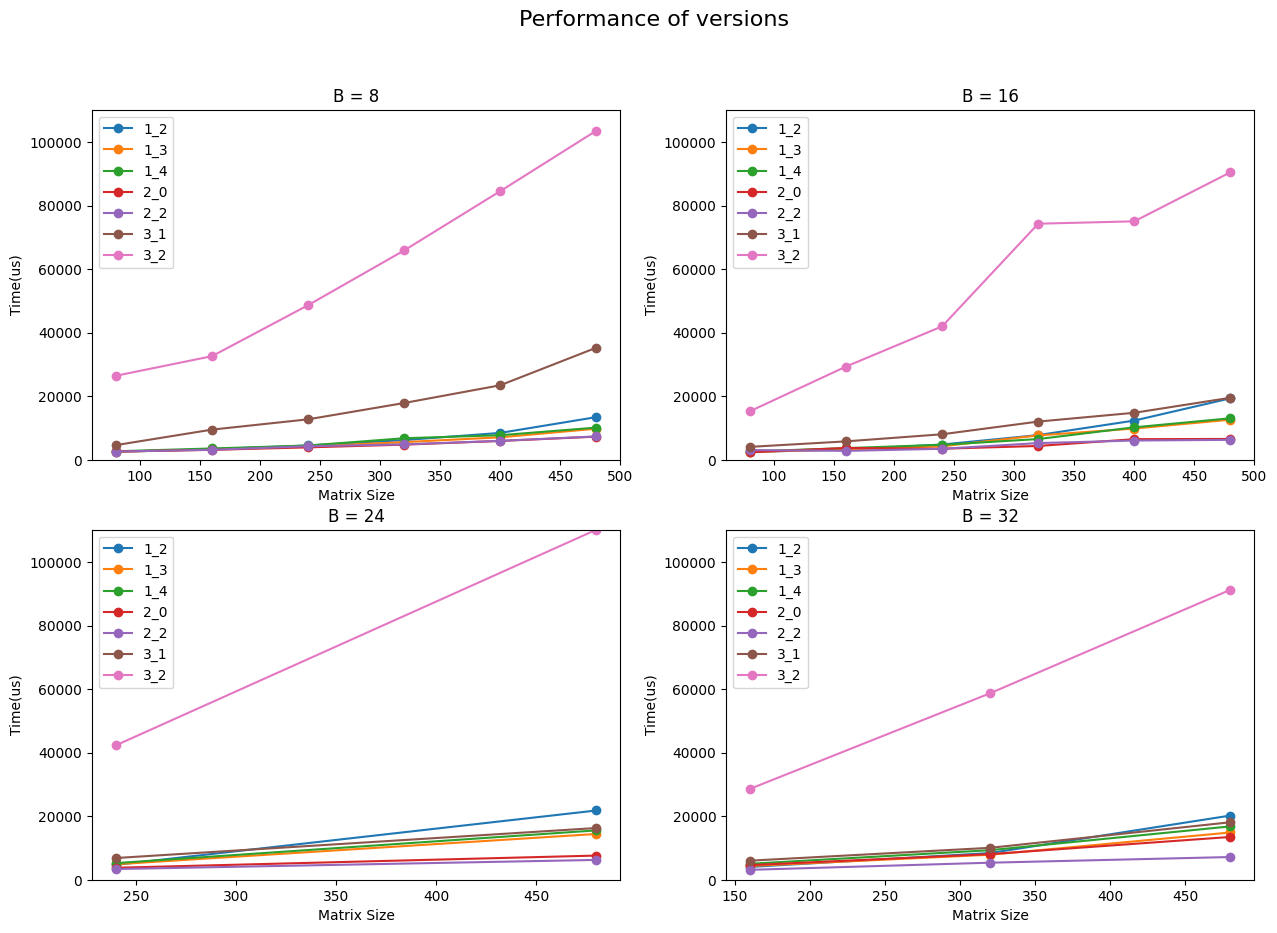

In [72]:
rows = 2
cols = 2
fig, axis = plt.subplots(rows, cols, figsize=(15, 10))
idx = 0
df_filtered = df_small[(df_small['version'] != '1_1')]
fig.suptitle("Performance of versions",  fontsize=16)
max_y = max(df_filtered['Time(us)'])
for b in range(8, 33, 8):
    i = (int) (idx / 2)
    j = (int) (idx % 2)
    df_plot = df_filtered[(df_filtered['b'] == b)]
    for label, grp in df_plot.groupby(['version']):
        sub_title = "B = " + str(b)
        grp.plot(ax=axis[i][j], kind='line', x='n', y='Time(us)', xlabel='Matrix Size', ylabel='Time(us)', label=label, title=sub_title, ylim=(0,max_y), marker='o')
    idx += 1

plt.savefig('png/versions_performance.png', facecolor='white', transparent=False)

In [73]:
versions = np.unique(df_small['version'])
versions = versions.tolist()
versions.remove('1_1')
print(versions)

['1_2', '1_3', '1_4', '2_0', '2_2', '3_1', '3_2']


IndexError: index 2 is out of bounds for axis 0 with size 2

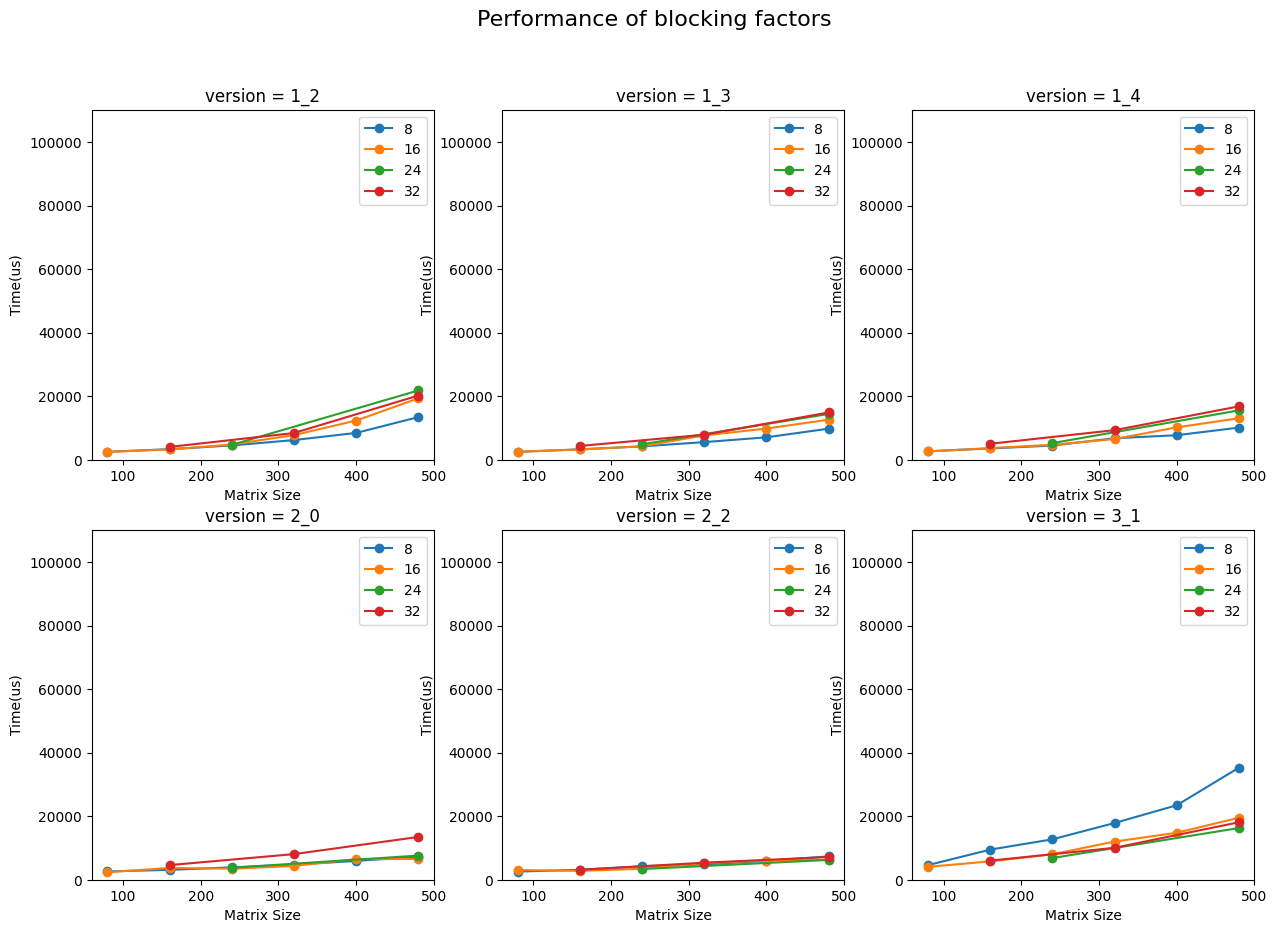

In [74]:
rows = 2
cols = 3
fig, axis = plt.subplots(rows, cols, figsize=(15, 10))
idx = 0
df_filtered = df_small[(df_small['version'] != '1_1')]
fig.suptitle("Performance of blocking factors",  fontsize=16)
max_y = max(df_filtered['Time(us)'])
for v in versions:
    i = (int) (idx / 3)
    j = (int) (idx % 3)
    df_plot = df_filtered[(df_filtered['version'] == v)]
    for label, grp in df_plot.groupby(['b']):
        sub_title = "version = " + v
        grp.plot(ax=axis[i][j], kind='line', x='n', y='Time(us)', xlabel='Matrix Size', ylabel='Time(us)', label=label, title=sub_title, ylim=(0,max_y), marker='o')
    idx += 1

plt.savefig('png/blocking_factors_performance.png', facecolor='white', transparent=False)

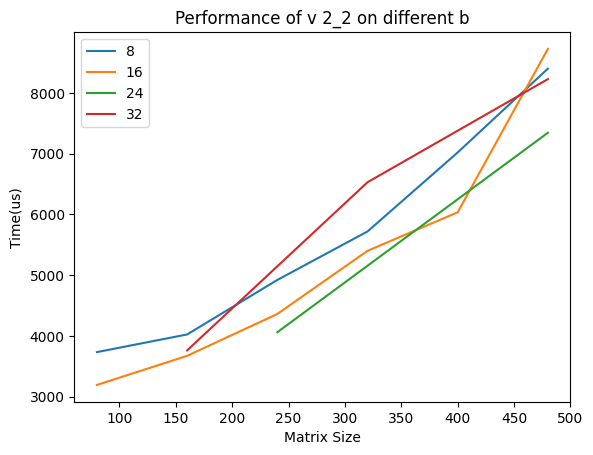

In [ ]:
df_plot = df_small[(df_small['version'] == '2_2')] # & (df_small['b'] == 32)]
#df_plot = df_small.query("version == '2_2'")
fig, ax = plt.subplots()
for label, grp in df_plot.groupby(['b']):
    plt.title("Performance of v 2_2 on different b")
    ax = grp.plot(ax=ax, kind='line', x='n', y='Time(us)', xlabel='Matrix Size', ylabel='Time(us)', label=label)